In [2]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd
from IPython.display import clear_output
import scipy.sparse as sp
import plotly.graph_objects as go
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns

In [5]:
graph_df = pd.read_csv("./data/small_graphs/squirrel/musae_squirrel_edges.csv")
names = pd.read_csv('./data/wiki-topcats-page-names.txt.gz', compression='gzip', header=None, sep='\t', quotechar='"')

squirells = nx.from_pandas_edgelist(graph_df, source="id1", target="id2")
n = squirells.number_of_nodes()

In [3]:
print(squirells)
nodes = squirells.nodes()

Graph with 5201 nodes and 198493 edges


In [4]:
nodes = list(nodes)
print([[node] for node in nodes])

[[3475], [2849], [3106], [808], [4555], [3563], [1527], [3327], [402], [4066], [3908], [2820], [4903], [715], [5112], [817], [4855], [5057], [4481], [3975], [2408], [2539], [4236], [3372], [4303], [4658], [3829], [5078], [313], [4410], [777], [3609], [5122], [4650], [5093], [4862], [2930], [169], [5067], [3700], [2238], [2890], [4544], [2371], [5123], [1481], [1039], [3668], [1654], [1883], [4796], [2173], [3644], [4664], [1316], [4965], [5194], [2219], [3630], [3603], [3253], [3413], [4989], [2972], [5074], [2958], [3691], [4419], [5125], [3909], [4346], [5196], [4365], [3852], [4847], [3730], [3891], [4434], [4730], [4758], [792], [4598], [5050], [5115], [4088], [4471], [3310], [5121], [514], [3078], [5126], [4616], [1548], [4621], [5132], [4625], [4627], [2068], [4629], [5142], [4120], [5145], [5146], [2040], [5148], [4638], [5150], [4640], [4128], [4129], [5160], [2089], [3115], [5164], [5165], [5169], [5174], [2103], [4665], [4158], [1087], [4160], [5186], [5189], [3142], [3143], 

## Result analysis functions

In [6]:
def visualize_clusters_plotly(graph, clusters, title="Visualisation des clusters (Plotly)"):
    """
    Visualise les clusters extraits en coloriant chaque cluster différemment avec Plotly.
    
    Arguments :
        graph : networkx.Graph
            Le graphe à visualiser.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.
        title : str
            Le titre du graphique.
    """
    pos = nx.spring_layout(graph, seed=42)  # Disposition des nœuds
    edge_x = []
    edge_y = []

    # Dessiner les arêtes
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Dessiner les nœuds
    node_traces = []
    colors = plt.cm.get_cmap("tab10", len(clusters))
    
    for i, cluster in enumerate(clusters):
        node_x = []
        node_y = []
        for j in range(len(cluster)):
            if cluster[j]==1:
                x, y = pos[j]
                node_x.append(x)
                node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    # Créer la figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")


def visualize_names_and_clusters_plotly(graph, clusters=None, title="Visualisation des noms et clusters (Plotly)"):
    pos = nx.spring_layout(graph, seed=42)
    edge_x, edge_y = [], []

    graphnodes = list(graph.nodes())

    # Draw edges
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    # Draw nodes
    node_traces = []
    
    if clusters is not None and len(clusters) > 0:
        colors = plt.cm.get_cmap("tab10", len(clusters))
        # Create a trace for each cluster
        for i, cluster in enumerate(clusters):
            # Filter cluster nodes to only those present in the graph
            cluster_nodes = [graphnodes[n] for n, is_in in enumerate(cluster) if is_in]
            
            if not cluster_nodes:
                continue
                
            try:
                node_x = [pos[node][0] for node in cluster_nodes]
                node_y = [pos[node][1] for node in cluster_nodes]
                node_text = [graph.nodes[node].get("name", f"Node {node}") for node in cluster_nodes]
                
                node_trace = go.Scatter(
                    x=node_x, y=node_y,
                    mode="markers",
                    marker=dict(
                        size=10,
                        color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                        line_width=2
                    ),
                    text=node_text,
                    hoverinfo="text",
                    name=f"Cluster {i + 1}"
                )
                node_traces.append(node_trace)
            except KeyError as e:
                print(f"Warning: Could not process cluster {i+1}, node {e} not found in graph")
                continue
    else:
        # Single trace for all nodes if no clusters
        node_x = [pos[node][0] for node in graph.nodes()]
        node_y = [pos[node][1] for node in graph.nodes()]
        node_text = [graph.nodes[node].get("name", f"Node {node}") for node in graph.nodes()]
        
        node_traces = [go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(size=10, color="#1f78b4", line_width=2),
            text=node_text,
            hoverinfo="text"
        )]

    # Create figure
    fig = go.Figure(
        data=[edge_trace] + node_traces,
        layout=go.Layout(
            title=title,
            titlefont_size=16,
            showlegend=True,
            hovermode="closest",
            margin=dict(b=0, l=0, r=0, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False)
        )
    )

    fig.show(renderer="browser")

In [7]:
def plot_cluster_sizes(clustering):
    nb_per_cluster = np.sum(clustering,axis=1)

    plt.bar(np.arange(len(clustering))+1, np.sort(nb_per_cluster)[::-1])
    plt.title("Number of nodes per cluster")
    plt.ylabel("Number of nodes")
    plt.show()

def number_of_clusters_under(clustering, limit):
    return np.sum(np.sum(clustering,axis=1) <= limit)

def global_modularity(cluster_to_nodes, G):
    A = nx.adjacency_matrix(G).toarray()
    m = G.number_of_edges()
    degrees = np.array(list(G.degree()))[:,1].astype(float)

    node_to_clusters  = np.argmax(cluster_to_nodes, axis=0)
    same_cluster = node_to_clusters[:,None] == node_to_clusters[None,:]

    L = np.sum(A*same_cluster)/2
    k = np.array([np.sum(degrees[node_to_clusters == i]) for i in range(cluster_to_nodes.shape[0])])

    return (L/m - np.sum((k/(2*m))**2))

## Intersection over Union

In [5]:
def bottom_up_clustering(G, limit=50, plot_crits = True):
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_adjacency = A.copy() #- np.diag(np.diagonal(A)) # Every node starts in its own cluster and we remove loops
    cluster_degrees = np.sum(cluster_adjacency, axis=1)

    union_matrix = cluster_degrees[:,None] + cluster_degrees[None,:] - cluster_adjacency
    nonzero_union_matrix = np.maximum(union_matrix, .9)
    criterion_matrix = cluster_adjacency / nonzero_union_matrix # Intersection over union

    cluster_to_nodes = np.eye(n)

    max_crits = []

    for k in range(n, 0, -1):
        if k == limit or k == 1:
            break

        # Find the best clusters to merge
        random_argmax = np.random.choice(np.flatnonzero(criterion_matrix == criterion_matrix.max())) # Randomize argmax tiebreak aiming for less top heavy clustering
        best_c1, best_c2 = np.unravel_index(random_argmax, criterion_matrix.shape)

        #best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]
        
        max_crits.append(max_crit)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        if best_c1 == best_c2:
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]
        cluster_to_nodes[k-1] = 0

        cluster_adjacency[best_c1] += cluster_adjacency[best_c2]
        cluster_adjacency[best_c1, best_c1] = 0
        cluster_adjacency[:, best_c1] = cluster_adjacency[best_c1]

        cluster_degrees[best_c1] += cluster_degrees[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:
            cluster_adjacency[best_c2] = cluster_adjacency[k - 1]
            cluster_adjacency[:, best_c2] = cluster_adjacency[best_c2]
            cluster_adjacency[best_c2, best_c2] = 0
            cluster_adjacency[best_c1, best_c2] = cluster_adjacency[best_c1, k - 1] + cluster_adjacency[best_c2, k - 1]
            
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = 0

            cluster_degrees[best_c2] = cluster_degrees[k - 1]

        cluster_adjacency[k-1] = 0
        cluster_adjacency[:, k-1] = 0 
        cluster_degrees[k-1] = 0     

        # Update Criterion Matrix
        union = cluster_degrees + cluster_degrees[best_c1] - cluster_adjacency[best_c1]
        criterion_matrix[best_c1] = cluster_adjacency[best_c1] / np.maximum(union, .5) # Intersection over union
        criterion_matrix[:, best_c1] = criterion_matrix[best_c1]

        criterion_matrix[k-1] = 0
        criterion_matrix[:, k-1] = 0

        # Reduce dimensions to k*k # actually increases compute time so commented out for now
        #if False and not k%1000:
        #    cluster_adjacency = cluster_adjacency[:k - 1, :k - 1]
        #    cluster_degrees = cluster_degrees[:k - 1]
        #    criterion_matrix = criterion_matrix[:k - 1, :k - 1]

        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+1)

    # Delete empty clusters
    final_cluster_to_nodes = []
    for i,cluster in enumerate(cluster_to_nodes):
        if cluster.sum() > 10e-2:  # tolerance for digit imprecision
            final_cluster_to_nodes.append(cluster)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)

    if plot_crits:
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")
        plt.show()

    return final_cluster_to_nodes, max_crits

## Neighborhood similarity

In [ ]:
def bottom_up_clustering_v2(G, limit, plot_crits = True, plot_modularity = False): # Neighborhood similarity criterion
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_neighborhoods = nx.adjacency_matrix(G).tolil() # sparse matrix for faster multiplication

    cluster_sizes = np.ones(n)

    print("Computing criterion")
    criterion_matrix = cluster_neighborhoods @ cluster_neighborhoods #/ np.maximum(cluster_degrees[:,None], .9) # Neighborhood similarity normalized by cluster size (1 at init)
    criterion_matrix = criterion_matrix.todense()
    np.fill_diagonal(criterion_matrix, -1) # Remove self similarity

    cluster_to_nodes = np.eye(n, dtype=np.int32)
    max_crits = []

    if plot_modularity:
        degrees = np.array(list(G.degree()))[:,1].astype(np.float64)
        modularities = []
        m = G.number_of_edges()
        node_to_cluster = np.arange(n)
        same_cluster_matrix = np.eye(n)


    print("Finished init")

    for k in range(n, limit, -1):
        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+2)

        # Find the best clusters to merge
        random_argmax = np.random.choice(np.flatnonzero(criterion_matrix == criterion_matrix.max())) # Randomize argmax tiebreak aiming for less top heavy clustering
        best_c1, best_c2 = np.unravel_index(random_argmax, criterion_matrix.shape)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        #best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]
        
        max_crits.append(max_crit)

        if best_c1 == best_c2:
            print("Problem : Merging same cluster")
            print("Criterion :", criterion_matrix[best_c1, best_c1])
            print("Iteration", n-k)
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]
        cluster_to_nodes[k-1] = 0
        # Compute modularity
        if plot_modularity:
            node_to_cluster[cluster_to_nodes[best_c1]] = best_c1
            # same_cluster_matrix += node_to_cluster[best_c1,None] == node_to_cluster[None,best_c1]
            #same_cluster_matrix = np.minimum(same_cluster_matrix, 1)

            same_cluster_matrix = node_to_cluster[None,:] == node_to_cluster[:,None]

            L = np.sum(A * same_cluster_matrix)/2
            k_array = np.array([np.sum(degrees[node_to_cluster == i]) for i in range(k)])
            modularity = (L/m - np.sum((k_array/(2*m))**2))
            modularities.append(modularity)

            if modularity == max(modularities):
                best_clustering = cluster_to_nodes.copy()

        #Update criterion matrix

        #In order to avoid recomputing matrix multiplications, we can simply de-normalize the criterions of c1 and c2, add them together and re-normalize
        #This works because the new cluster will have the same neighborhood as the sum of the two clusters
        numerator = criterion_matrix[best_c1] * (cluster_sizes[best_c1] * cluster_sizes) + criterion_matrix[best_c2] * (cluster_sizes[best_c2] * cluster_sizes) # De-normalze and sum
        criterion_matrix[best_c1] =  numerator / ((cluster_sizes[best_c1] + cluster_sizes[best_c2]) * cluster_sizes) # Re-normalize

        criterion_matrix[:,best_c1] = criterion_matrix[best_c1]
        criterion_matrix[best_c1, best_c1] = -1 # Remove self similarity

        cluster_sizes[best_c1] += cluster_sizes[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:         
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = -1

            cluster_sizes[best_c2] = cluster_sizes[k - 1]  

        criterion_matrix[k-1] = -1
        criterion_matrix[:, k-1] = -1           


    # Delete empty clusters
    final_cluster_to_nodes = []
    for i,cluster in enumerate(cluster_to_nodes):
        if cluster.sum():
            final_cluster_to_nodes.append(cluster)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)

    # Debug prints
    print("Nonempty clusters found:", final_cluster_to_nodes.shape)
    print("Superposition nodes:", np.sum(np.sum(cluster_to_nodes, axis=0) > 1))

    if plot_crits:
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,max(max_crits)*1.1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")
        plt.show()

    if plot_modularity:
        plt.plot(modularities, color="darkorange")
        plt.grid(1)
        plt.title("Modularity per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Modularity")
        plt.show()
    
    return final_cluster_to_nodes, max_crits

In [25]:
def bottom_up_clustering_v3(G, limit, plot_crits = True, plot_modularity = False): # Neighborhood similarity criterion
    A = nx.adjacency_matrix(G).toarray()
    n = A.shape[0]
    cluster_neighborhoods = nx.adjacency_matrix(G).tolil() # sparse matrix for faster multiplication
    cluster_neighborhoods.setdiag(0)

    cluster_sizes = np.ones(n)

    print("Computing criterion")
    criterion_matrix = cluster_neighborhoods @ cluster_neighborhoods #/ np.maximum(cluster_degrees[:,None], .9) # Neighborhood similarity normalized by cluster size² (1 at init)
    criterion_matrix = criterion_matrix.todense()
    np.fill_diagonal(criterion_matrix, -1) # Remove self similarity
    cluster_neighborhoods = cluster_neighborhoods.todense()

    cluster_to_nodes = np.eye(n, dtype=np.int32)
    max_crits = []

    if plot_modularity:
        modularities= []
        nodes = list(G.nodes())
        cluster_list_list = [[nodes[i]] for i in range(n)]

    print("Finished init")

    for k in range(n, limit, -1):
        # Progress bar update
        progress = int((n - k) / (n - limit) * 100)
        str_progress = "=" * progress + ">" * (progress < 100) + " " * (100 - progress)
        clear_output(wait=True)
        print("[", end="")
        print(str_progress, end="")
        print("]")
        print("Iteration", n-k+1)

        # Find the best clusters to merge
        random_argmax = np.random.choice(np.flatnonzero(criterion_matrix == criterion_matrix.max())) # Randomize argmax tiebreak aiming for less top heavy clustering
        best_c1, best_c2 = np.unravel_index(random_argmax, criterion_matrix.shape)
        best_c1, best_c2 = min(best_c1, best_c2), max(best_c1, best_c2)

        #best_c1, best_c2 = np.unravel_index(np.argmax(criterion_matrix), criterion_matrix.shape)
        max_crit = criterion_matrix[best_c1, best_c2]
        
        max_crits.append(max_crit)
        
        if best_c1 == best_c2:
            print("Problem : Merging same cluster")
            print("Criterion :", criterion_matrix[best_c1, best_c1])
            print("Iteration", n-k)
            raise ValueError("No bueno amigo")

        # Merge clusters
        cluster_to_nodes[best_c1] += cluster_to_nodes[best_c2]
        if plot_modularity:
            cluster_list_list[best_c1].extend(cluster_list_list[best_c2])
            #cluster_list_list.pop(best_c2)
            cluster_list_list[best_c2] = cluster_list_list[k-1]
            cluster_list_list[k-1] = []
            modularity = nx.algorithms.community.quality.modularity(G, cluster_list_list)
            modularities.append(modularity)

            if modularity == max(modularities):
                best_clustering = cluster_to_nodes.copy()

        cluster_neighborhoods[best_c1] += cluster_neighborhoods[best_c2]
        cluster_neighborhoods[best_c1, cluster_to_nodes[best_c1] > 0 ] = 0 # Keep only external neighborhood
        #cluster_neighborhoods[best_c1] = np.minimum(cluster_neighborhoods[best_c1], 1) # clip to 1

        cluster_sizes[best_c1] += cluster_sizes[best_c2]

        # Copy cluster k to cluster index best_c2
        if best_c2 != k - 1:         
            criterion_matrix[best_c2] = criterion_matrix[k-1]
            criterion_matrix[:, best_c2] = criterion_matrix[best_c2]
            criterion_matrix[best_c2, best_c2] = -1

            cluster_neighborhoods[best_c2] = cluster_neighborhoods[k - 1]

            cluster_sizes[best_c2] = cluster_sizes[k - 1]

            cluster_to_nodes[best_c2] = cluster_to_nodes[k-1]

        #Update criterion matrix

        #In this case where we only consider external neighborhood, we cannot simply sum the criterions 
        # as the new cluster similarity vector cannot be trivially deduced from the sum of the two previous ones
        criterion_matrix[best_c1] = cluster_neighborhoods[best_c1] @ cluster_neighborhoods.T / (cluster_sizes[best_c1] * cluster_sizes) # Neighborhood similarity normalized by cluster size
        criterion_matrix[:, best_c1] = criterion_matrix[best_c1]
        criterion_matrix[best_c1, best_c1] = -1 # Remove self similarity

        criterion_matrix[k-1] = -1
        criterion_matrix[:, k-1] = -1
        cluster_to_nodes[k-1] = 0
        cluster_sizes[k-1] = 0

        cluster_neighborhoods[k-1] = 0

        #if k%200 == 0:
        #    # Reduce dimensions to k*k
        #    cluster_neighborhoods = cluster_neighborhoods[:k - 1]
        #    criterion_matrix = criterion_matrix[:k - 1, :k - 1]
        #    cluster_sizes = cluster_sizes[:k - 1]
        #    cluster_to_nodes = cluster_to_nodes[:k - 1]

    # Delete empty clusters
    final_cluster_to_nodes = []
    final_best_clustering= []
    for cluster, best_c in zip(cluster_to_nodes, best_clustering):
        if cluster.sum():
            final_cluster_to_nodes.append(cluster)
        if best_c.sum():
            final_best_clustering.append(best_c)

    final_cluster_to_nodes = np.array(final_cluster_to_nodes)
    final_best_clustering = np.array(final_best_clustering)

    # Debug prints
    print("Nonempty clusters found:", final_cluster_to_nodes.shape)
    print("Superposition nodes:", np.sum(np.sum(cluster_to_nodes, axis=0) > 1))

    if plot_crits:
        plt.figure(figsize = (5,3))
        plt.plot(max_crits)
        plt.grid(1)
        plt.ylim([0,max(max_crits)*1.1])
        plt.title("Max criterion per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Criterion")

        sns.despine()
        plt.savefig(
            "Bottomup_criterion.pdf",
            format="pdf",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0.05
        )
        
        plt.show()

    if plot_modularity:
        plt.figure(figsize = (5,3))
        plt.plot(modularities, color="darkorange")
        plt.grid(1)
        plt.title("Modularity per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Modularity")

        sns.despine()
        plt.savefig(
            "Bottomup_modularity.pdf",
            format="pdf",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0.05
        )
        plt.show()
    if plot_modularity:
        return final_cluster_to_nodes, final_best_clustering
    
    return final_cluster_to_nodes, max_crits

## Small test on Karate graph

In [8]:
karate = nx.karate_club_graph()
karatepos = nx.spring_layout(karate)

[================================================================================================>    ]
Iteration 33
Nonempty clusters found: (2, 34)
Superposition nodes: 0


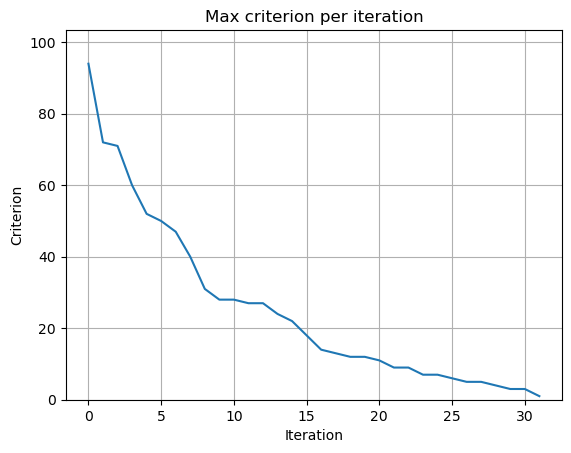

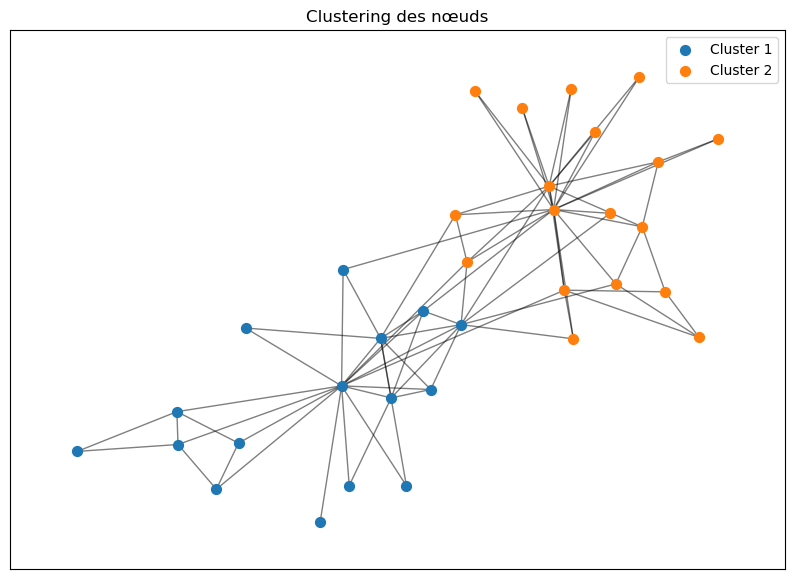

Clustering modularity : 4.358974358974359


In [11]:
karate_clusters = bottom_up_clustering_v2(karate, limit = 2)[0]

plt.figure(figsize=(10, 7))
for i, cluster in enumerate(karate_clusters):
    nx.draw_networkx_nodes(
        karate, karatepos,
        nodelist=[n for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(karate, karatepos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds")
plt.show()

node_to_cluster = np.argmax(karate_clusters.T == np.arange(karate.number_of_nodes())[:, None], axis=1)

same_cluster_matrix_karate = node_to_cluster[:, None] == node_to_cluster[None, :]

print("Clustering modularity :",global_modularity(karate_clusters, karate))

## Tests on Squirell graph

[===================================================================================================> ]
Iteration 5102
Nonempty clusters found: (100, 5201)
Superposition nodes: 0


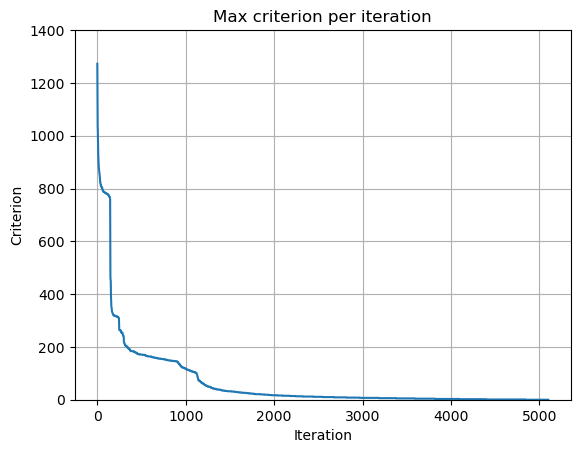

[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [23]:
clusters_v2, crits = bottom_up_clustering_v2(squirells, limit = 100)
print(clusters_v2)

44


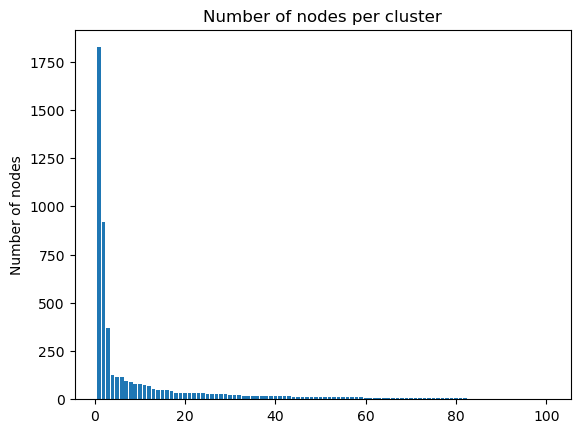

In [24]:
print(number_of_clusters_under(clusters_v2, 10))
plot_cluster_sizes(clusters_v2)

In [ ]:
clusters = bottom_up_clustering(squirells, limit = 30)
print(clusters)

[=>                                                                                                   ]
Iteration 56


KeyboardInterrupt: 

In [ ]:
node_to_cluster = np.argmax(clusters.T == np.arange(n)[:, None], axis=1)

same_cluster_matrix = node_to_cluster[:, None] == node_to_cluster[None, :]
print("Bottom up clustering modularity : ",global_modularity(same_cluster_matrix, clusters, squirells))

Bottom up clustering modularity :  0.9864554417536134


In [ ]:
node_to_cluster = np.argmax(clusters_v2.T == np.arange(n)[:, None], axis=1)

same_cluster_matrix = node_to_cluster[:, None] == node_to_cluster[None, :]
print("Bottom up clustering v2 modularity : ",global_modularity(same_cluster_matrix, clusters_v2, squirells))

Bottom up clustering v2 modularity :  0.9858911901175357


In [ ]:
print(global_modularity(clusters_v2, squirells))

0.1703158297773725


In [25]:
pos = nx.spring_layout(squirells)  # Positionnement des nœuds pour la visualisation

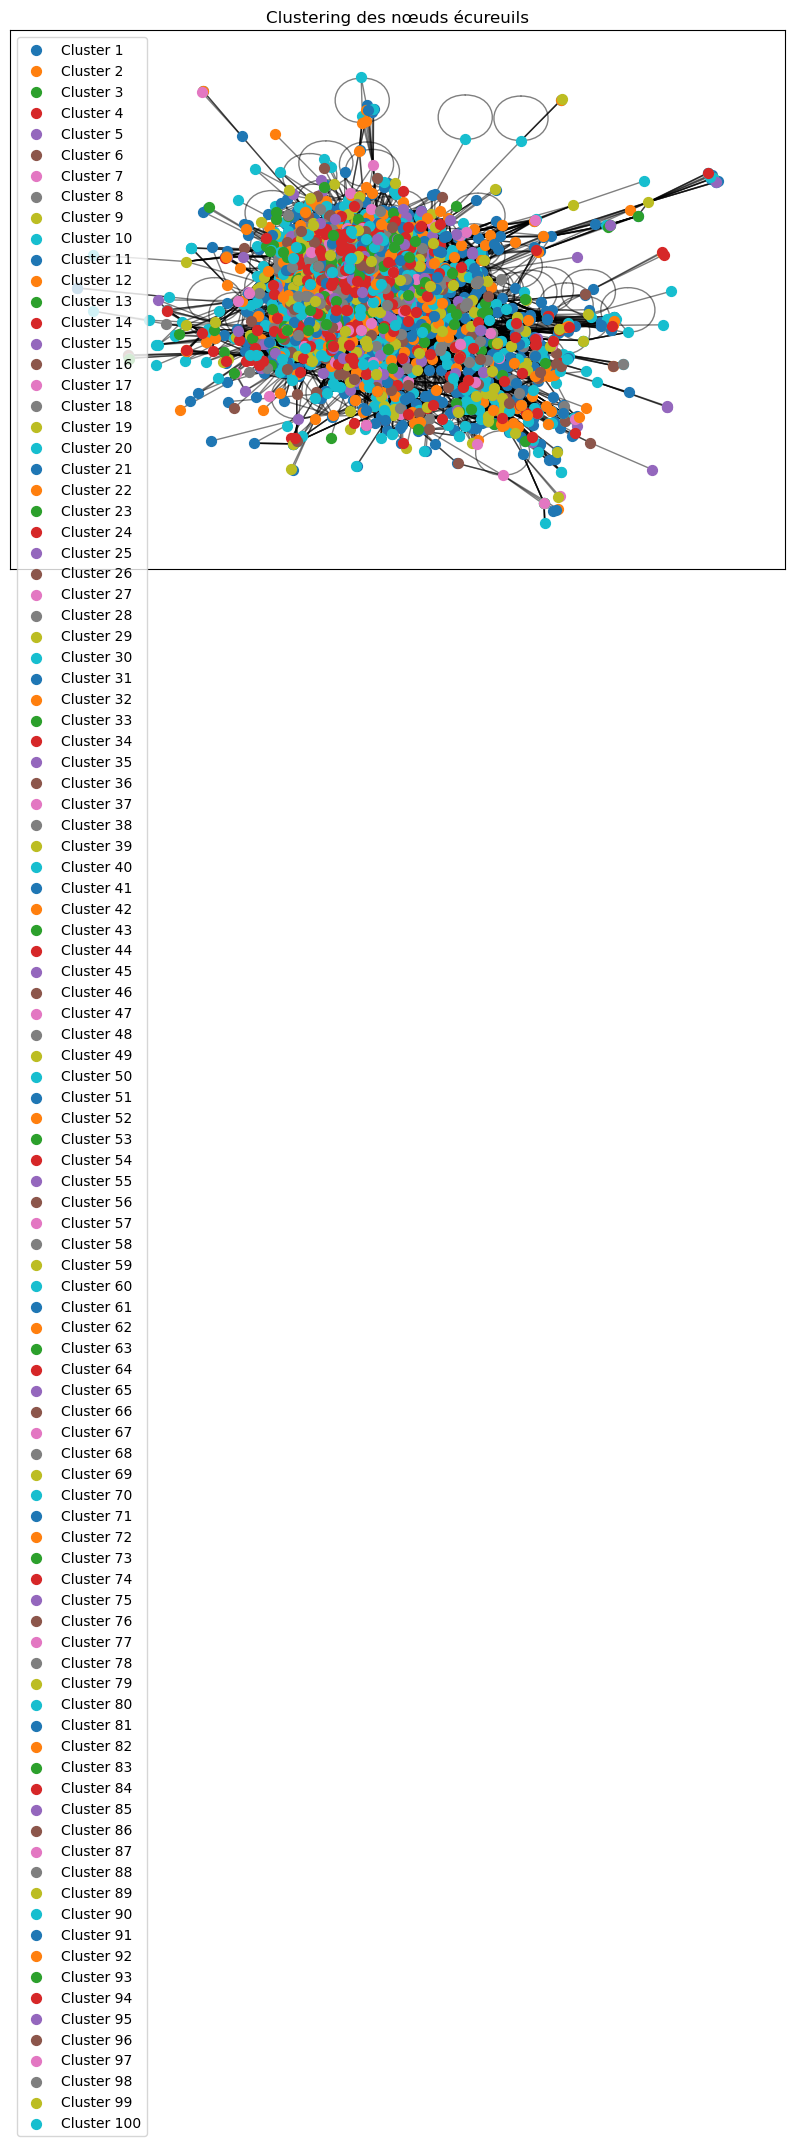

In [26]:
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(clusters_v2):
    nx.draw_networkx_nodes(
        squirells, pos,
        nodelist=[n for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(squirells, pos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds écureuils")
plt.show()

In [ ]:
visualize_clusters_plotly(squirells, clusters_v2)

## Tests on subset of big G

In [10]:
bigG = nx.read_edgelist("./data/big_graph/wiki-topcats.txt.gz")

In [11]:
big_degrees = list(bigG.degree())
big_degrees = np.array(big_degrees)[:,1].astype(int)

In [17]:
onek_biggest = np.argsort(big_degrees)[-1000:]

In [12]:
import gzip

def load_page_names(file_path):
    page_names = {}
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            line = line.strip()
            if not line:  # Ignorer les lignes vides
                continue
            parts = line.split(' ', 1)
            if len(parts) == 2:  # Vérifier que la ligne contient bien deux parties
                page_id, page_name = parts
                page_names[page_id] = page_name
    return page_names

page_names = load_page_names("data/big_graph/wiki-topcats-page-names.txt.gz")


nx.set_node_attributes(bigG, page_names, "name")

In [13]:
subnodes = np.array(list(bigG.nodes())[:1000])#[onek_biggest]
subnames = names.iloc[:1000,0]
subG = bigG.subgraph(subnodes)
subg_nodes = list(subG.nodes())

print("Total graph :",bigG)
print("Studied subset :",subG)

Total graph : Graph with 1791489 nodes and 25447873 edges
Studied subset : Graph with 1000 nodes and 4628 edges


[===================================================================================================> ]
Iteration 996
Nonempty clusters found: (5, 1000)
Superposition nodes: 0


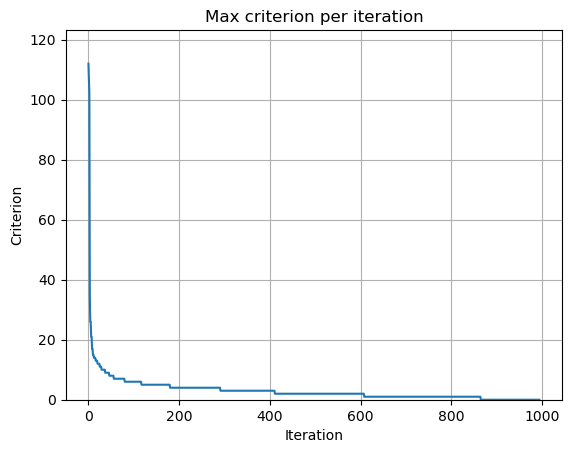

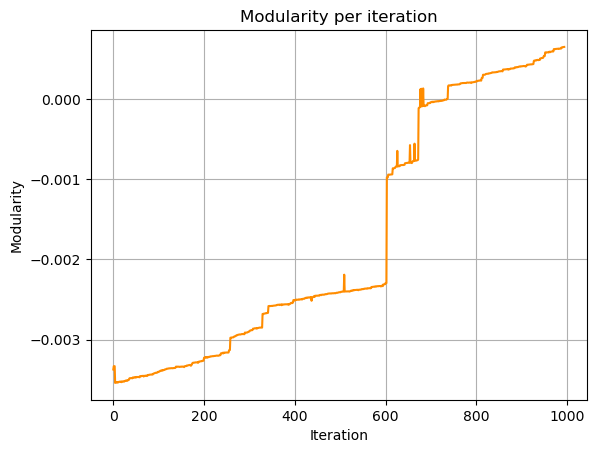

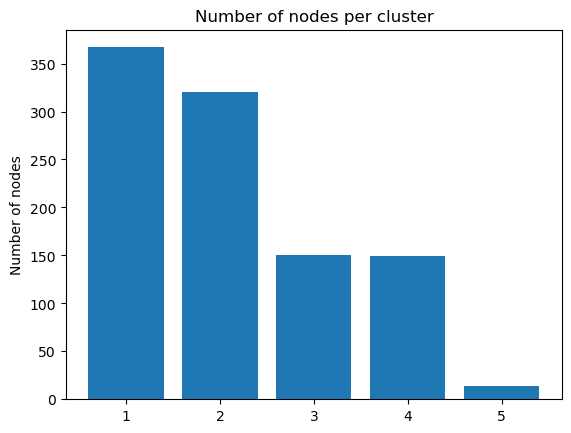

In [139]:
subg_clustering, subg_crits = bottom_up_clustering_v2(subG, limit = 5, plot_modularity=True)

plot_cluster_sizes(subg_clustering)

In [ ]:
subpos = nx.spring_layout(subG)

In [ ]:
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(subg_clustering):
    nx.draw_networkx_nodes(
        subG, subpos,
        nodelist=[subg_nodes[n] for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(subG, subpos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds")
plt.show()

In [18]:
# Map the node indices to a continuous range starting from 0
mapping = {node: i for i, node in enumerate(subG.nodes())}
subG_continuous = nx.relabel_nodes(subG, mapping)
subg_clustering_continuous = subg_clustering[:, list(mapping.values())]

visualize_clusters_plotly(subG_continuous, subg_clustering_continuous)

C:\Users\melvi\AppData\Local\Temp\ipykernel_12328\2561155747.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



[===================================================================================================> ]
Iteration 995
Nonempty clusters found: (54, 1000)
Superposition nodes: 0


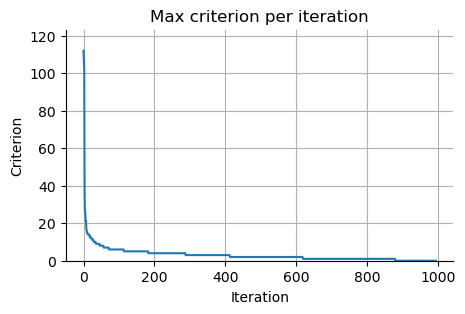

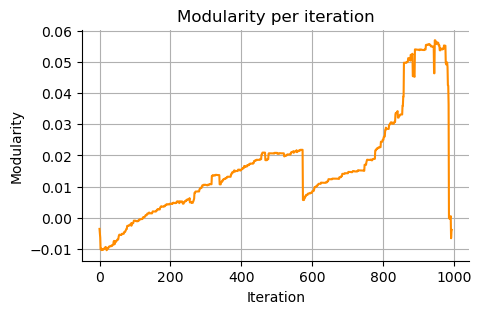

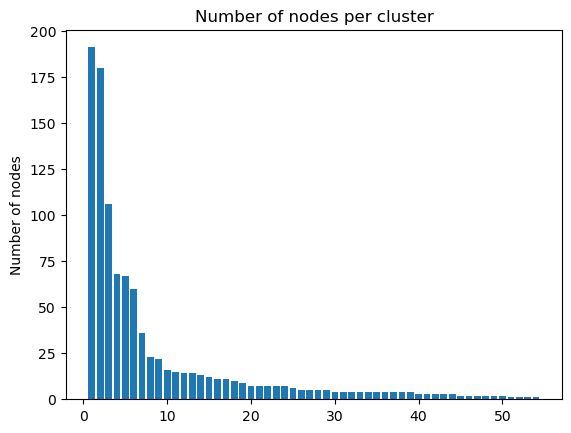

In [ ]:
#np.random.seed(22)
best_clustering2, subg_clustering2 = bottom_up_clustering_v3(subG, limit = 5, plot_modularity=True)

plot_cluster_sizes(subg_clustering2)

In [ ]:
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(subg_clustering2):
    nx.draw_networkx_nodes(
        subG, subpos,
        nodelist=[subg_nodes[n] for n, l in enumerate(cluster) if l == 1],
        node_size=50,  # Ajuster la taille des nœuds
        node_color=f"C{i}",  # Utiliser une couleur différente pour chaque cluster
        label=f"Cluster {i+1}"
    )
nx.draw_networkx_edges(subG, subpos, alpha=0.5)
plt.legend()
plt.title("Clustering des nœuds")
plt.show()

In [42]:
# Map the node indices to a continuous range starting from 0
mapping = {node: i for i, node in enumerate(subG.nodes())}
subG_continuous = nx.relabel_nodes(subG, mapping)
subg_clustering_continuous = subg_clustering2[:, list(mapping.values())]

visualize_clusters_plotly(subG_continuous, subg_clustering_continuous)

C:\Users\melvi\AppData\Local\Temp\ipykernel_12328\2561155747.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [142]:
print(global_modularity(subg_clustering, subG))
print(global_modularity(subg_clustering2, subG))

0.04419159260567934
-0.010949985769234505


In [141]:
node_to_subg_clustering2 = np.argmax(subg_clustering2, axis=0)

clustering = [[] for _ in range(5)]

for i in range(len(node_to_subg_clustering2)):
    clustering[node_to_subg_clustering2[i]].append(subnodes[i])

# Calculate modularity
modularity = nx.algorithms.community.quality.modularity(subG, clustering)
print("Modularity of subg_clustering2:", modularity)

Modularity of subg_clustering2: -0.0022621687985423865


## Cluster interpretation

In [23]:
visualize_names_and_clusters_plotly(subG, subg_clustering2)

C:\Users\melvi\AppData\Local\Temp\ipykernel_2008\3720528048.py:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [112]:
visualize_names_and_clusters_plotly(subG, subg_clustering)

C:\Users\melvi\AppData\Local\Temp\ipykernel_18116\3720528048.py:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:
for i, cluster in enumerate(subg_clustering):
    size = np.sum(cluster)
    print("Cluster", i, "size :", size)
    ceiling = min(size, 100)
    nodes = np.random.choice(np.nonzero(cluster)[0], ceiling)
    print(names.iloc[:,0].iloc[nodes])
    print("")

Cluster 0 size : 216
(1000,) ()
862              862 Takabuti
212       212 Michael Gunther
617         617 Discoderoides
716    716 Descarpentriesiola
665           665 Sphenoptera
                ...          
105         105 Robert Hecker
756            756 Latipalpis
462            462 Deyrollius
401              401 Maoraxia
654            654 Melobasina
Name: 0, Length: 100, dtype: object

Cluster 1 size : 264
(1000,) ()
628                    628 Helferina
509                      509 Zitella
296            296 Anthaxia nitidula
85     85 13th century in literature
182             182 Krener's theorem
                   ...              
404                   404 Xenorhipis
830                   830 Neocypetes
652                652 Haplotrinchus
470                     470 Asymades
918                    918 Metiamide
Name: 0, Length: 100, dtype: object

Cluster 2 size : 299
(1000,) ()
264        264 Spanish Fly (2003 film)
689                       689 Bordonia
213          21

## Cities

In [24]:
import osmnx as ox

In [25]:
paris = ox.graph_from_place('Sevres, France', network_type='drive', simplify =True)

[===================================================================================================> ]
Iteration 350
Nonempty clusters found: (3, 352)
Superposition nodes: 0


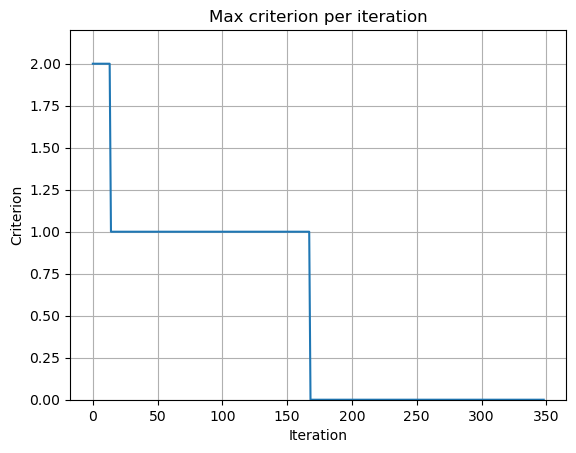

In [26]:
paris_clusters, paris_crits = bottom_up_clustering_v2(paris, limit = 3)

node_to_cluster = np.argmax(paris_clusters, axis=0)

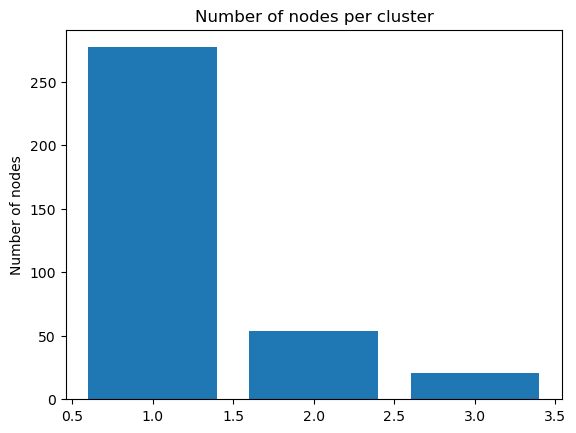

In [27]:
plot_cluster_sizes(paris_clusters)

In [31]:
node_to_cluster

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2,
       0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,

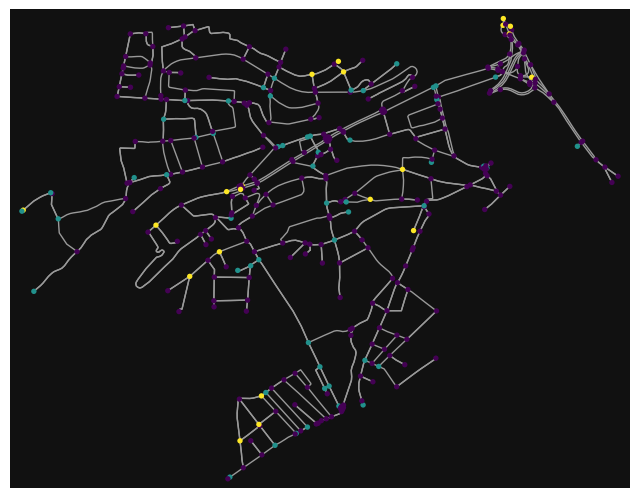

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
ox.plot.plot_graph(paris, node_color=node_to_cluster)